## Importing libraries

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
import random

## Setting seed

In [2]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [3]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)


## Getting the training set and the test set

In [4]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [5]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [6]:
input_tensor = Input(shape=(224, 224, 3))

base_model = MobileNet(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

C:\Users\jakub\AppData\Local\Temp\ipykernel_16240\423565354.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_tensor=input_tensor, weights='imagenet')


## Data augmentation and training the model

In [7]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)


history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 18118.4688 - mae: 100.8828 - val_loss: 8192.7646 - val_mae: 69.6179
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 7412.5400 - mae: 68.9302 - val_loss: 6484.1079 - val_mae: 60.3169
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 5514.3589 - mae: 52.4624 - val_loss: 4829.6963 - val_mae: 49.9851
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 3665.6052 - mae: 42.4164 - val_loss: 4029.1116 - val_mae: 39.3030
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 3062.1062 - mae: 38.1574 - val_loss: 3912.4375 - val_mae: 37.2438
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 2661.8447 - mae: 34.2845 - val_loss: 3394.9763 - val_mae: 35.3139
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 2299.5759 - mae: 32.4492 - val_loss: 2813.8896 - val_mae: 32.5557
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 2196.2688 - mae: 32.5316 - val_loss: 2567.2307 - val_mae: 31.7246
Epoch 

## Training curves visualisation

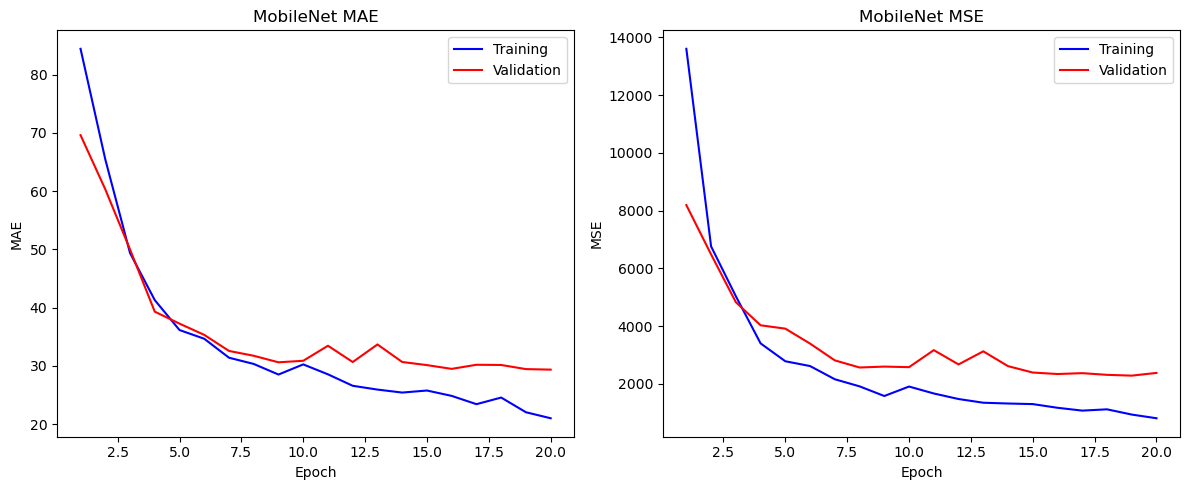

In [8]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('MobileNet MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('MobileNet MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


## Making predictions

In [9]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 800ms/step


Layers:

'input_layer', 'conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu', 'flatten', 'dropout', 'dense', 'dropout_1', 'dense_1', 'dense_2'

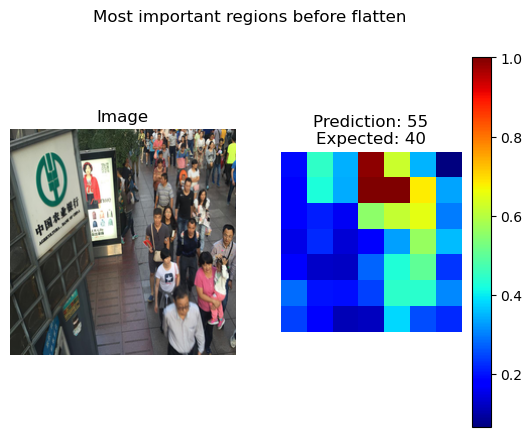

In [24]:
# Sample
image = X_test[20:21]

# Layer
last_conv_layer_name = 'conv_pw_13_relu'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = (image[0] + 1.0) / 2.0
plt.suptitle("Most important regions before flatten")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[20]}")

plt.show()

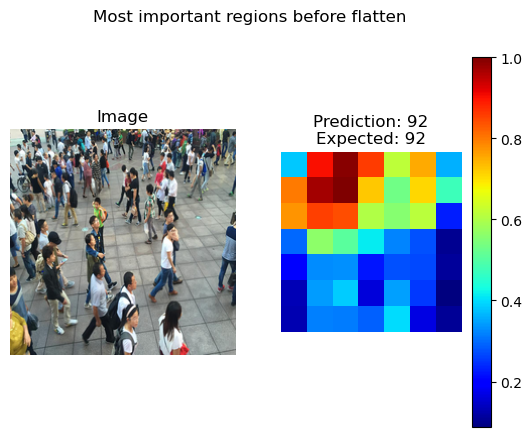

In [25]:
# Sample
image = X_test[211:212]

# Layer
last_conv_layer_name = 'conv_pw_13_relu'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = (image[0] + 1.0) / 2.0
plt.suptitle("Most important regions before flatten")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[211]}")

plt.show()

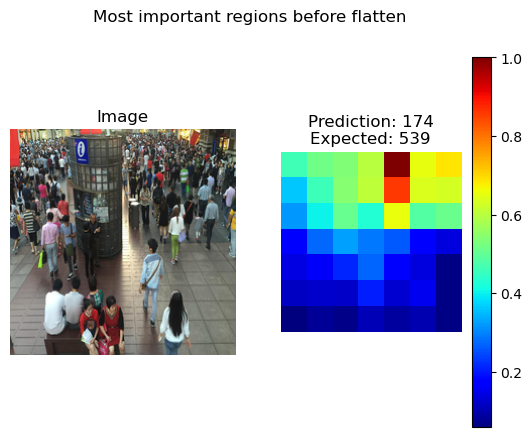

In [26]:
# Sample
image = X_test[289:290]

# Layer
last_conv_layer_name = 'conv_pw_13_relu'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = (image[0] + 1.0) / 2.0
plt.suptitle("Most important regions before flatten")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[289]}")
plt.show()

In [27]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 20.  23.]
 [152. 181.]
 [162. 157.]
 [ 44.  37.]
 [ 71.  70.]
 [ 68.  57.]
 [ 55.  44.]
 [276. 227.]
 [241. 165.]
 [295. 476.]
 [157. 139.]
 [241. 316.]
 [185. 164.]
 [135. 110.]
 [ 50.  20.]
 [136. 131.]
 [ 53.  48.]
 [156. 183.]
 [170. 101.]
 [151. 204.]
 [ 55.  40.]
 [109. 143.]
 [150. 146.]
 [278. 513.]
 [ 84.  70.]
 [115. 175.]
 [ 49.  51.]
 [ 81.  55.]
 [ 96.  67.]
 [ 59.  72.]
 [ 54.  56.]
 [145. 165.]
 [ 39.  32.]
 [171. 149.]
 [ 60.  48.]
 [116.  80.]
 [ 90. 117.]
 [122. 162.]
 [161. 137.]
 [110. 120.]
 [ 61.  72.]
 [132. 122.]
 [170. 198.]
 [119. 133.]
 [119. 147.]
 [ 47.  29.]
 [ 59.  70.]
 [ 30.  35.]
 [112.  24.]
 [232. 251.]
 [ 61.  59.]
 [115.  67.]
 [ 44.  61.]
 [234. 248.]
 [207. 252.]
 [207. 147.]
 [ 49.  57.]
 [110. 121.]
 [ 67.  47.]
 [330. 505.]
 [269. 297.]
 [262. 465.]
 [127. 167.]
 [ 30.  43.]
 [ 36.  46.]
 [141.  91.]
 [271. 263.]
 [127.  92.]
 [ 66. 117.]
 [ 61.  48.]
 [ 56.  54.]
 [ 94.  73.]
 [112. 122.]
 [ 45.  60.]
 [256. 170.]
 [138. 167.]
 [ 69.  57.]

## Metrics

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.7369323968887329
MSE: 2380.800537109375
MAE: 29.34493637084961
RMSE: 48.79344940185547
